In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

In [2]:
trainData = torchvision.datasets.CIFAR10(root = "cifar10-train", train= True, download= True, transform= T.ToTensor())
testData = torchvision.datasets.CIFAR10(root = "cifar10-test", train= False, download= True, transform= T.ToTensor())

100%|██████████| 170M/170M [00:05<00:00, 30.8MB/s] 
100%|██████████| 170M/170M [00:03<00:00, 44.3MB/s] 


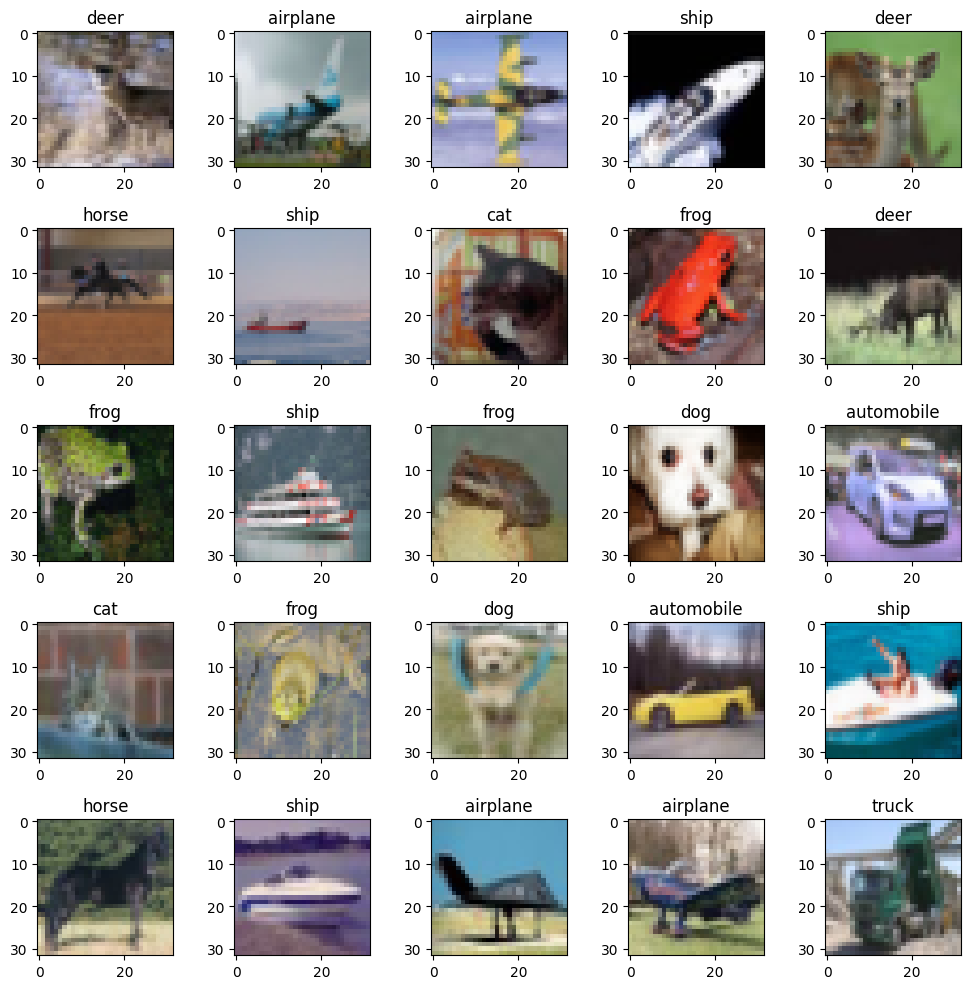

In [3]:
# Inspecting few random images

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for ax in axs.flatten():
  randomIdx = np.random.choice(len(trainData.targets))
  img = trainData[randomIdx][0]
  lable = trainData.classes[trainData[randomIdx][1]]
  ax.title.set_text(lable)
  ax.imshow(img.permute(1,2,0))
plt.tight_layout()
plt.show()

### Creating Train/Dev/Test Loader

In [4]:
dev_size = int(0.5*len(testData))
test_size = len(testData) - dev_size
test_data, dev_data = random_split(testData, [test_size, dev_size])

train_loader = DataLoader(trainData, batch_size= 32, shuffle= True, drop_last= True)
dev_loader = DataLoader(dev_data, batch_size= len(dev_data))
test_loader = DataLoader(test_data, batch_size= len(test_data))

### Make the Net

In [5]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(3,64,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: (32+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(64,128,3)
      self.bnorm2 = nn.BatchNorm2d(128) # input the number of channels in this layer
      # output size: (16+2*0-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      # third convolution layer
      self.conv3  = nn.Conv2d(128,256,3)
      self.bnorm3 = nn.BatchNorm2d(256) # input the number of channels in this layer
      # output size: (7+2*0-3)/1 + 1 = 5/2 = 2 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(2*2*256,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64,10)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPBR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.5,training=self.training) # training=self.training means to turn off during eval mode
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [6]:
## Test the model with one batch data
X,y = next(iter(train_loader))
net, lossfun, optimizer = makeTheNet(True)
yHat = net(X)
print(yHat.shape)

Input: [32, 3, 32, 32]
First CPBR block: [32, 64, 16, 16]
Second CPR block: [32, 128, 7, 7]
Third CPR block: [32, 256, 2, 2]
Vectorized: [32, 1024]
Final output: [32, 10]
torch.Size([32, 10])


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [8]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc  = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    ### test performance
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.inference_mode(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

    print(f"Epoch: {epochi+1}  | Train Accuracy: {trainAcc[epochi]:.2f}% | Dev Accuracy: {devAcc[epochi]:.2f}%")

  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

In [9]:
trainLoss,devLoss,trainAcc,devAcc,net = function2trainTheModel()

Epoch: 1  | Train Accuracy: 47.57% | Dev Accuracy: 55.52%
Epoch: 2  | Train Accuracy: 63.87% | Dev Accuracy: 67.74%
Epoch: 3  | Train Accuracy: 70.81% | Dev Accuracy: 72.32%
Epoch: 4  | Train Accuracy: 74.68% | Dev Accuracy: 75.82%
Epoch: 5  | Train Accuracy: 78.23% | Dev Accuracy: 73.06%
Epoch: 6  | Train Accuracy: 80.90% | Dev Accuracy: 75.96%
Epoch: 7  | Train Accuracy: 82.95% | Dev Accuracy: 78.58%
Epoch: 8  | Train Accuracy: 84.92% | Dev Accuracy: 77.14%
Epoch: 9  | Train Accuracy: 86.46% | Dev Accuracy: 78.80%
Epoch: 10  | Train Accuracy: 87.87% | Dev Accuracy: 75.04%


In [10]:
## the real test set!

net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.inference_mode():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

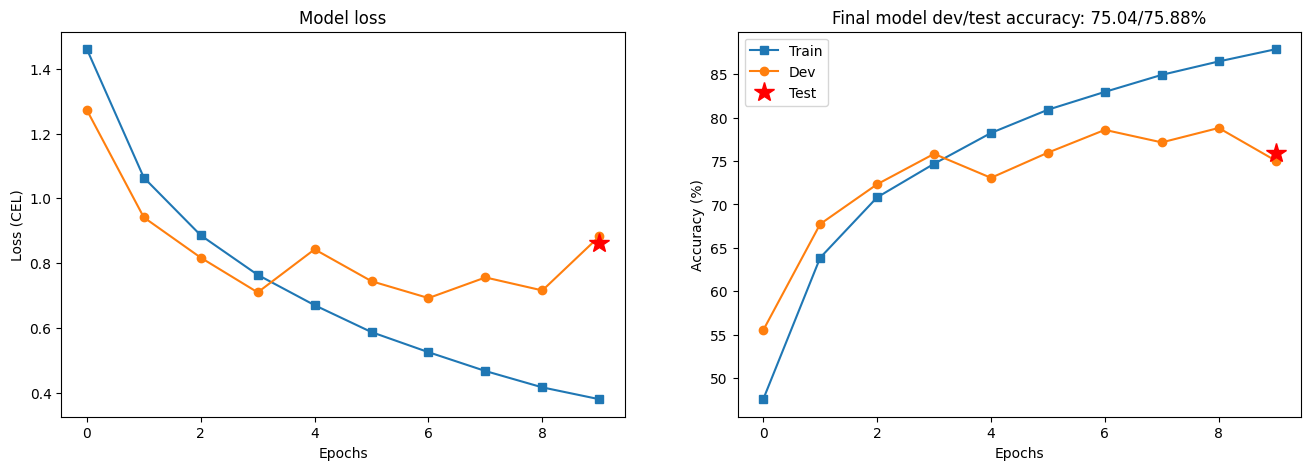

In [11]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()